In [ ]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt

In [ ]:
pgm_path = '/content/color_checker.pgm'
bayer = io.imread(pgm_path).astype(np.uint16)

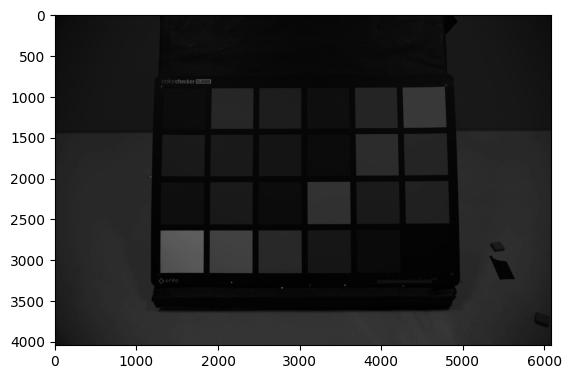

In [ ]:
# plt.imshow(bayer, cmap = 'gray')

In [ ]:
# plt.imshow(bayer[:50, :50], cmap = 'gray')

Gradient Based Filter for Dead Pixel Concealment (DPC)

In [ ]:
def DPC(bayer, thresh):
  """
  inputs:
    bayer = raw bayer domain image
    thresh = threshold value

  outputs:
    dpc_img = bayer domain image with dead pixels corrected for with gradient filter
  """

  dpc_img = np.copy(bayer)  # create a copy of the bayer image to fix dead pixels in
  rows, cols = np.shape(bayer)
  padded_bayer = np.pad(bayer, (2,2), mode = 'reflect') # pad image to allow for 5x5 filter

  for i in range(2, rows+2, 1):
    for j in range(2, cols+2, 1):
      # iterate over every pixel in the original bayer image

      p_0 = padded_bayer[i, j]
      p_1 = padded_bayer[i-2, j-2]
      p_2 = padded_bayer[i-2, j]
      p_3 = padded_bayer[i-2, j+2]
      p_4 = padded_bayer[i, j-2]
      p_5 = padded_bayer[i, j+2]
      p_6 = padded_bayer[i+2, j-2]
      p_7 = padded_bayer[i+2, j]
      p_8 = padded_bayer[i+2, j+2]
      neighbors = np.array([p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8])

      diff = np.abs(neighbors - p_0)  # for dead pixel detection

      if np.sum(diff > thresh) >= 1:
        # if dead pixel is detected, the run gradient based correction
        dv = (p_2 + p_7 + 1) // 2
        dh = (p_4 + p_5 + 1) // 2
        ddr = (p_1 + p_8 + 1) // 2
        ddl = (p_3 + p_6 + 1) // 2

        dpc_img[i-2, j-2] = min(dv, dh, ddr, ddl) # add the corrected pixel value to the copied image

  return dpc_img

In [ ]:
thresh = np.max(bayer) * 0.05
dpc_img = DPC(bayer, thresh)
# plt.imshow(dpc_img, cmap = 'gray')

Black Level Compensation (BLC)


In [ ]:
def BLC(dpc_img, offsets):
  """
  inputs:
    dpc_img = bayer domain image after dead pixel concealment
    offsets = dictionary with black level offset values, keys (bl_r, bl_gr, bl_gb, bl_b)

  outputs:
    blc_img = bayer domain image with adjusted black levels
  """

  rows, cols = dpc_img.shape
  blc_img = np.empty((rows, cols)) # create a blank image with the same size as the bayer image to adjust black levels in


  for i in range(rows):
    for j in range(cols):
      if (i % 2 == 0) & (j % 2 == 0): # if row and col index = even, handling red pixel
        blc_img[i, j] = dpc_img[i, j] + offsets['bl_r']
      elif (i % 2 == 0) & (j % 2 != 0): # if row index = even and col index = odd, handling green pixel on red row
        blc_img[i, j] = dpc_img[i, j] + offsets['bl_gr']
      elif (i % 2 != 0) & (j % 2 == 0): # if row index = odd and col index = even, handline green pixel on blue row
        blc_img[i, j] = dpc_img[i, j] + offsets['bl_gb']
      elif (i % 2 != 0) & (j % 2 != 0): # if row and col index = odd, handling blue pixel
        blc_img[i, j] = dpc_img[i, j] + offsets['bl_b']

  return np.clip(blc_img, 0, None)

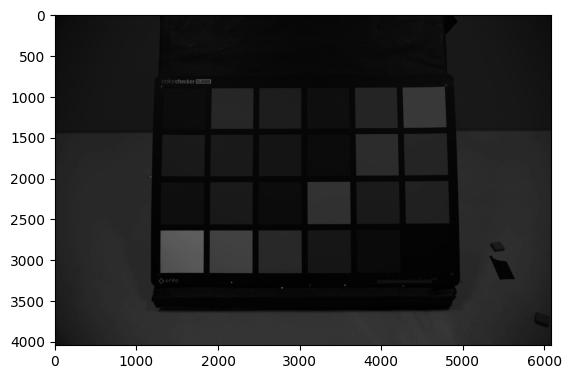

In [ ]:
offsets = {'bl_r':-10, 'bl_gr':-10, 'bl_gb':-10, 'bl_b':-10}
blc_img = BLC(dpc_img, offsets)
# plt.imshow(blc_img, cmap = 'gray')

Lens Shading Correction (LSC)

In [ ]:
def LSC(blc_img, k, offset):
  """
  inputs:
    blc_img = bayer domain image after black level compensation
    k = correction factor to control strength of the correction
    offset = offset in case the final image is too bright

  outputs:
    lsc_img = bayer domain image adjusted for lens shading
  """

  lsc_img = np.copy(blc_img) # create a copy of the bayer image to adjust lens shading in
  rows, cols = blc_img.shape
  center_row = (rows // 2) + 1 # store indeces for the center of the image
  center_col = (cols // 2) + 1

  for i in range(rows):
    for j in range(cols):
      r = ( (i - center_row)**2 + (j - center_col)**2 )**0.5 # radial distance to the current pixel
      lsc_img[i, j] = int( blc_img[i, j] * (k * r + 1) - offset)

  return np.clip(lsc_img, 0, (2**16 - 1))

In [ ]:
k = 0.0015
offset = 0
lsc_img = LSC(blc_img, k, offset)
# plt.imshow(lsc_img, cmap = 'gray')

Anti-Aliasing Noise Filter (AAF)

In [ ]:
def AAF(lsc_img, k):
  """
  inputs:
    lsc_img = bayer domain image after lens shading correcting
    k = anti-aliasing correction factor to control strenght of anti-aliasing

  outputs:
    aaf_img = bayer domain image after applying anti-aliasing
  """

  filter = np.array([
      [1, 0, 1, 0, 1],
      [0, 0, 0, 0, 0],
      [1, 0, k, 0, 1],
      [0, 0, 0, 0, 0],
      [1, 0, 1, 0, 1]
  ]) / (k+8) # define filter for a weighted average over neighboring pixels

  rows, cols = lsc_img.shape
  aaf_img = np.empty((rows, cols)) # create an empty array the size of the bayer image to apply anti-aliasing in
  padded_img = np.pad(lsc_img, (2,2), 'reflect') # pad image to allow filter to work on image edges

  for i in range(2, rows+2):
    for j in range(2, cols+2):
      aaf_img[i-2, j-2] = np.sum(filter * padded_img[i-2:i+3, j-2:j+3]) # compute the dot product using the filter and neighbor pixels

  return aaf_img

In [ ]:
k = 8
aaf_img = AAF(lsc_img, k)
# plt.imshow(aaf_img, cmap = 'gray')

Auto White Balance Gain Control (AWB)

In [ ]:
def AWB(aaf_img):
  """
  inputs:
    aaf_img = bayer domain image after anti-aliasing noise filter

  outputs:
    awb_img = bayer domain image after auto white balance
  """

  awb_img = np.copy(aaf_img) # create a copy of the bayer image to apply auto white balance

  r = awb_img[::2, ::2] # use array splicing to extract r, gr, gb, and b pixels from the full bayer image
  gr = awb_img[::2, 1::2]
  gb = awb_img[1::2, ::2]
  b = awb_img[1::2, 1::2]

  r_ave = np.sum(r) / r.size # compute averages of r, g, and b channels
  g_ave = (np.sum(gr) + np.sum(gb)) / (gr.size + gb.size)
  b_ave = np.sum(b) / b.size

  r_gain = g_ave / r_ave # compute gains for r, g, and b channels
  g_gain = g_ave / g_ave
  b_gain = g_ave / b_ave

  awb_img[::2, ::2] = r * r_gain # apply gains to r, g, and b channels
  awb_img[::2, 1::2] = gr * g_gain
  awb_img[1::2, ::2] = gb * g_gain
  awb_img[1::2, 1::2] = b * b_gain

  return awb_img

2.5529661958066807


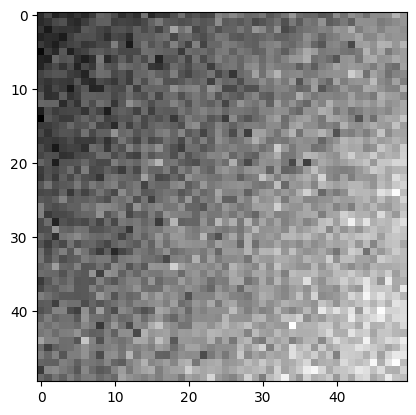

In [ ]:
awb_img = AWB(bayer[:50, :50])
# plt.imshow(awb_img, cmap = 'gray')

Color Filter Array Interpolation (CFA) using Bilinear Interpolation technique and loops


In [ ]:
def CFA(awb_img):
  """
  inputs:
    awb_img = bayer domain image after auto white balance gain control

  outputs:
    cfa_img = 8 bit RGB image
  """

  awb_img = awb_img.astype(np.uint32) # change dtype to allow for larger numbers during demosaicing
  rows, cols = awb_img.shape
  r = np.empty((rows, cols))
  g = np.empty((rows, cols))
  b = np.empty((rows, cols))
  padded_img = np.pad(awb_img, (1,1), 'reflect')
  max_val = np.max(awb_img)

  for i in range(1, rows+1):
    for j in range(1, cols+1):
      if (i % 2 == 0) & (j % 2 == 0): # if row and col index = even, handling red pixel
        """
        red pixel is directly read off the bayer image
        green pixel is average of surrounding 4 green pixels (N, E, S, W)
        blue pixel is average of surrounding 4 blue pixels (NE, SE, SE, SW)
        """
        r[i-1, j-1] = padded_img[i,j]
        g[i-1, j-1] = (padded_img[i-1, j] + padded_img[i+1, j] + padded_img[i, j-1] + padded_img[i, j+1]) // 4
        b[i-1, j-1] = (padded_img[i-1, j-1] + padded_img[i-1, j+1] + padded_img[i+1, j-1] + padded_img[i+1, j+1]) // 4

      elif (i % 2 == 0) & (j % 2 != 0): # if row index = even and col index = odd, handling green pixel on red row
        """
        red pixel is average of right and left red pixels (E, W)
        green pixel is directly read off the bayer image
        blue pixel is average of top and bottom blue pixels (N, S)
        """
        r[i-1, j-1] = (padded_img[i, j-1] + padded_img[i, j+1]) // 2
        g[i-1, j-1] = padded_img[i,j]
        b[i-1, j-1] = (padded_img[i-1, j] + padded_img[i+1, j]) // 2

      elif (i % 2 != 0) & (j % 2 == 0): # if row index = odd and col index = even, handline green pixel on blue row
        """
        red pixel is average of top and bottom red pixels (N, S)
        green pixel is directly read off the bayer image
        blue pixel is average of right and left blue pixels (E, W)
        """
        r[i-1, j-1] = (padded_img[i, j-1] + padded_img[i, j+1]) // 2
        g[i-1, j-1] = padded_img[i,j]
        b[i-1, j-1] = (padded_img[i-1, j] + padded_img[i+1, j]) // 2

      elif (i % 2 != 0) & (j % 2 != 0): # if row and col index = odd, handling blue pixel
        """
        red pixel is average of surrounding 4 red pixels (NE, SE, SE, SW)
        green pixel is average of surrounding 4 green pixels (N, E, S, W)
        blue pixel is directly read off the bayer image
        """
        r[i-1, j-1] = (padded_img[i-1, j-1] + padded_img[i-1, j+1] + padded_img[i+1, j-1] + padded_img[i+1, j+1]) // 4
        g[i-1, j-1] = (padded_img[i-1, j] + padded_img[i+1, j] + padded_img[i, j-1] + padded_img[i, j+1]) // 4
        b[i-1, j-1] = padded_img[i,j]

  r = np.clip(r, 0, max_val) # ensure all values are of the correct range before stacking
  g = np.clip(g, 0, max_val)
  b = np.clip(b, 0, max_val)

  cfa_img = np.dstack((r, g, b)) # stack red, green, and blue channels dimensionally to create an RGB image
  cfa_img = ( (cfa_img / max_val) * 255).astype(np.uint8)

  return cfa_img

In [ ]:
cfa_img = CFA(awb_img)
# plt.imshow(cfa_img)

Gamma Correction (GAC)

In [ ]:
def GAC(cfa_img, gamma):
  """
  inputs:
    cfa_img = RGB image right after demosaicing
    gamma = correction factor

  outputs:
    gac_img = RGB imgae after gamma correction
  """

  cfa_img = cfa_img.astype(np.uint16) # change dtype to allow for larger numbers during gamma correction
  gac_img = cfa_img**(1 / gamma) # apply gamma correction
  max_val = np.max(gac_img)

  gac_img = ( (gac_img / max_val) * 255).astype(np.uint8) # resize the RGB image to 8 bit integer and skip the CCM

  return gac_img

In [ ]:
gamma = 2.2
gac_img = GAC(cfa_img, gamma)
# plt.imshow(gac_img)

Color Space Conversion (CSC)

In [ ]:
def CSC(gac_img):
  """
  inputs:
    gac_img = RGB image after gamma correction

  outputs:
    y = gray scale image as y channel (luma)
    cbcr_img = color information (chroma)
  """

  r = gac_img[:, :, 0] # seperate R, G, and B channels
  g = gac_img[:, :, 1]
  b = gac_img[:, :, 2]

  y = 0.299 * (r/255) + 0.587 * (g/255) + 0.114 * (b/255) # apply the convesrion formulas
  cb = 0.564 * ( (b/255) - y)
  cr = 0.713 * ( (r/255) - y)

  cbcr_img = np.dstack((cb, cr)) # chroma image

  return y, cbcr_img

In [ ]:
def YCbCr_to_RGB(y, cbcr_img):
    """
    inputs:
      y = gray scale image as y channel (luma)
      cbcr_img = chroma color information (Cb and Cr channels)

    output:
      rgb_img = RGB image after conversion from YCbCr
    """

    cb = cbcr_img[:, :, 0] # seperate Cb and Cr channels
    cr = cbcr_img[:, :, 1]

    r = (y + (cr/0.713)).astype(np.uint8) # apply the convesrion formulas
    b = (y + (cb/0.564)).astype(np.uint8)
    g = ((y - 0.299*r - 0.114*b) / 0.587).astype(np.uint8)

    rgb_img = np.dstack((r, g, b)) # Stack R, G, and B channels to form the RGB image

    return rgb_img

In [ ]:
y, cbcr_img = CSC(gac_img)

'''
plt.subplot(1,3,1)
plt.imshow(y, cmap = 'gray')

plt.subplot(1,3,2)
plt.imshow(cbcr_img[:, :, 0], cmap = 'gray')

plt.subplot(1,3,3)
plt.imshow(cbcr_img[:, :, 1], cmap = 'gray')
'''

Noise Filter for Chroma (NFC)

In [ ]:
def NFC(cbcr_img, alpha, thresh):
  """
  inputs:
    cbcr_img = Cb and Cr channels of the YCbCr image
    alpha = controls intensity of correction for noisy pixels
    thresh = controls strictness of noisy pixel detection

  outputs:
    nfc_img = Cb and Cr channels of YCbCr image after applying noise filter on both
  """

  nfc_img = np.copy(cbcr_img) # make a copy of the cbcr_img to apply noise filter for chroma

  for k in range(2):
    # apply the filter to both Cb and Cr

    img = cbcr_img[:, :, k]
    editted_img = nfc_img[:, :, k]
    rows, cols = img.shape
    padded_img = np.pad(img, (2,2), 'reflect')

    for i in range(2, rows+2, 1):
      for j in range(2, cols+2, 1):
        # iterate over every pixel in the image

        neighbors = padded_img[i-2:i+3, j-2:j+3] # extract 5x5 section
        p0 = neighbors[2, 2] # extract p0

        # calculate mean of all neighboring pixels
        mean = ( np.sum(neighbors) - p0 ) / 24

        # calculate standard deviation of all neighboring pixels
        neighbors = neighbors - mean
        neighbors[2, 2] = 0 # remove p0 from neighbors to not affect standard dev calculations
        stand_dev = ( np.sum(neighbors**2) / 24 )**0.5

        if p0 < ( mean - (thresh * stand_dev) ) or p0 > ( mean + (thresh * stand_dev) ): # current pixel not w/in 2.5 * std, apply correction
          editted_img[i-2, j-2] = alpha * mean + (1 - alpha) * p0

    nfc_img[:, :, k] = editted_img

  return nfc_img.astype(np.uint8)

In [ ]:
alpha = 0.3
thresh = 2.5
nfc_img = NFC(cbcr_img, alpha, thresh)

'''
plt.subplot(131)
plt.imshow(nfc_img[:, :, 0], cmap = 'gray')

plt.subplot(132)
plt.imshow(nfc_img[:, :, 1], cmap = 'gray')

plt.subplot(133)
rgb_img = YCbCr_to_RGB(y, nfc_img)
plt.imshow(rgb_img)
'''

Hue Saturation Control (HSC)

In [ ]:
def HSC(nfc_img, delta_theta, s):
  """
  inputs:
    nfc_img = Cb and Cr channels after noise filter for chroma
    delta_theta = change in hue angle
    s = saturation correction intensity

  outputs:
    hsc_img = Cb and Cr channels after hue saturation control
  """

  nfc_img = nfc_img.astype(np.uint16) # change dtype to allow for larger numbers
  hsc_img = np.copy(nfc_img) # make a copy to apply hue saturation control in

  nfc_cb = nfc_img[:, :, 0] + 1 # add 1 to address divide by zero error
  nfc_cr = nfc_img[:, :, 1] + 1

  theta = np.arctan(nfc_cr/nfc_cb) # calculate current hue
  dist = (nfc_cb**2 + nfc_cr**2)**0.5 # calculate euclidain distance for use as normalizing factor

  hsc_cb = s * dist * np.cos(theta + delta_theta) # apply conversion formulas
  hsc_cr = s * dist * np.sin(theta + delta_theta)

  hsc_img[:, :, 0] = np.clip(hsc_cb, 0, 255).astype(np.uint8) # clip resulting cb and cr channels and set dtype
  hsc_img[:, :, 1] = np.clip(hsc_cr, 0, 255).astype(np.uint8)

  return hsc_img

In [ ]:
delta_theta = 0
s = 1
hsc_img = HSC(nfc_img, delta_theta, s)

'''
rgb_img = YCbCr_to_RGB(y, hsc_img)
plt.imshow(rgb_img)
'''

Noise Filter For Luma (NFL)

In [ ]:
def NFL(y):
  """
  inputs:
    y = gray scale image as y channel (luma)

  outputs:
    nfl_y = gray scale image as y channel (luma) after median noise filter
  """

  y = y.astype(np.uint16) # change dtype to allow for larger numbers
  nfl_y = np.copy(y) # copy y image to apply correction
  rows, cols = y.shape
  padded_img = np.pad(y, (1,1), 'reflect') # pad image to give edge pixels full set of neighbors

  for i in range(1, rows+1):
    for j in range(1, cols+1):
      nfl_y[i-1, j-1] = np.median(padded_img[i-1:i+2, j-1:j+2]) # apply median filter across all neighbors

  return nfl_y.astype(np.uint8) # return and rescale

In [ ]:
nfl_y = NFL(y)

'''
plt.subplot(121)
plt.imshow(nfl_y, cmap = 'gray')

plt.subplot(122)
rgb_img = YCbCr_to_RGB(nfl_y, hsc_img)
plt.imshow(rgb_img)
'''

Edge Enhancement Filter (EEF)

In [ ]:
def EEF(nfl_y, k):
  """
  inputs:
    nfl_y = y channel after noise filter for luma
    k = correction factor to control intensity of edge enhancement

  outputs:
    eef_y = y channel after edge enhancement filter
  """

  nfl_y = nfl_y.astype(np.uint32) # change dtype to allow for larger numbers
  rows, cols = nfl_y.shape
  padded_y = np.pad(nfl_y, (1,1), 'reflect')
  eef_y = np.copy(nfl_y) # copy y image to apply correction
  edges = np.empty(rows, cols)

  filter = np.array([
      [-1, -1, -1],
      [-1,  8, -1],
      [-1, -1, -1]
  ]) # define laplacian filter

  for i in range(1, rows+1):
    for j in range(1, cols+1):
      edges[i-1, j-1] = np.sum(padded_y[i-1:i+2, j-1:j+2] * filter) # extract edge map from lapacian

  scaled_edges = np.where(edges < 200, 0, edges) # scale edge map to only host strong edges
  eef_y = nfl_y + (k * scaled_edges) # add edge map back to original image to yield stronger edges

  return eef_y.astype(np.uint8)

In [ ]:
k = 1
eef_y = EEF(nfl_y, k)

'''
plt.subplot(121)
plt.imshow(eef_y, cmap = 'gray')

plt.subplot(122)
rgb_img = YCbCr_to_RGB(eef_y, hsc_img)
plt.imshow(rgb_img)
'''

Contrast Brightness Control (CBC)

In [ ]:
def CBC(eef_y, brightness_offset, new_max, new_min):
  """
  inputs:
    eef_y = y channel after edge enhancement filter applied
    brightness_offset = brightness control offset
    new_max = desired new maximum value
    new_min = desired new minimum value

  outputs:
    cbc_y = y channel after contrast brightness control
  """
  old_max = np.max(eef_y) # save useful values for contrast calculation
  old_min = np.min(eef_y)
  old_mid = (old_max + old_min) / 2
  new_mid = (new_max + new_min) / 2

  contrast_y = ( ( (eef_y - old_mid) * (new_max - new_min) ) / (old_max - old_min) ) + new_mid # calculate contrast

  cbc_y = np.clip(contrast_y + brightness_offset, 0, 240).astype(np.uint8) # apply correction and clip

  return cbc_y

In [ ]:
brightness_offset = 10
new_max = 240
new_min = 0
cbc_y = CBC(eef_y)

'''
plt.subplot(121)
plt.imshow(cbc_y, cmap = 'gray')

plt.subplot(122)
rgb_img = YCbCr_to_RGB(cbc_y, hsc_img)
plt.imshow(rgb_img)
'''

In [ ]:
rgb_img = YCbCr_to_RGB(cbc_y, hsc_img)
plt.imshow(rgb_img)